# Colorful Traces notebook

Here is the notebook we used to do some exploration about the data

Let's load it

In [1]:
import pandas as pd 
from urllib.request import urlopen
import xmltodict
import json
import matplotlib as plt
%matplotlib inline

In [2]:
def buildOSMNodeToLatLngDictionary(allOsmNodes):
    d = {}
    for p in allOsmNodes:
        d[p] = getLatLng(p)
    return d

def getLatLng(osmNode):
    file = urlopen('https://api.openstreetmap.org/api/0.6/node/' + str(osmNode))
    data = file.read()
    file.close()
    data = xmltodict.parse(data)
    return data['osm']['node']['@lat'], data['osm']['node']['@lon']

In [3]:
colorful = pd.read_csv("data/dataviz.csv", parse_dates=True )
colorful["road"] = colorful["road"].map(eval)
colorful["LengthRoad"] = colorful["road"].map(lambda x : len(x))
colorful["pnode"] =colorful["road"].map(lambda x :x[0])
colorful["dnode"] =colorful["road"].map(lambda x :x[-1])
colorful = colorful.drop(columns=["plat", "plng", "dlat", "dlng"])
colorful.to_csv("data/cleaned.csv")
colorful.head()

,t,road,LengthRoad,pnode,dnode
0,11:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",61,311463563,567914227
1,20:00:00,"[311463563, 2940544168, 311463564, 561463459, ...",234,311463563,560972953
2,18:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",346,311463563,3357408889
3,18:45:00,"[2223091605, 3786724165, 3786724164, 302530573...",125,2223091605,4601251537
4,19:00:00,"[3516999773, 3817926827, 567951313, 567951312,...",201,3516999773,1025496938


In [4]:
# Some stats about the 

from collections import Counter

counter =Counter()

def count_node(nodes):
    for n in nodes:
        counter[n] += 1
        
for nodes in colorful.road.tolist():
    count_node(nodes)



In [5]:
nodes = pd.DataFrame.from_dict(counter, orient="index", columns=["occurence"]).sort_values(by= "occurence", ascending=False)
nodes.head()

,occurence
2657469978,1103
155124152,1024
2223091605,996
2223091607,995
3786724226,995


In [6]:
allNodes = nodes.index.tolist()
len(allNodes)


12600

In [7]:
nodes["tuple-unique"] = 1
t_unique = nodes.groupby("occurence").count().sort_values(by="tuple-unique", ascending =False)
t_unique["percentage"] = t_unique["tuple-unique"].map(lambda x : x/t_unique["tuple-unique"].sum() *100)
t_unique.head(10)

,tuple-unique,percentage
occurence,,
1,2901,23.023810
2,1953,15.500000
3,1047,8.309524
4,751,5.960317
6,705,5.595238
5,604,4.793651
7,509,4.039683
8,318,2.523810
10,256,2.031746


Text(0.5,0,'number of nodes that appears x-times')

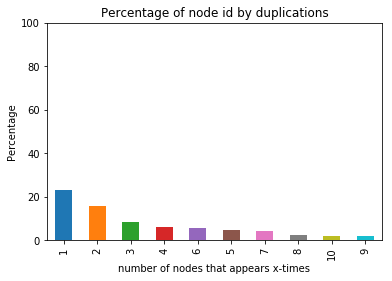

In [8]:
fig = t_unique["percentage"].head(10).plot.bar(ylim=[0, 100], title="Percentage of node id by duplications")
fig.yaxis.set_label_text("Percentage")
fig.xaxis.set_label_text("number of nodes that appears x-times")

In [9]:
pickup_group = colorful.groupby(by=["pnode"]).count().sort_values("road", ascending =False)

print("There are", len(pickup_group.index.tolist()), "different pickup locations.")

nb_pickups_by_pnode = pickup_group.drop(columns=["t", "road", "LengthRoad"])
nb_pickups_by_pnode = nb_pickups_by_pnode.rename(index=str, columns={"dnode": "nb of pickups"})



There are 42 different pickup locations.


There are 525 different drop off locations.


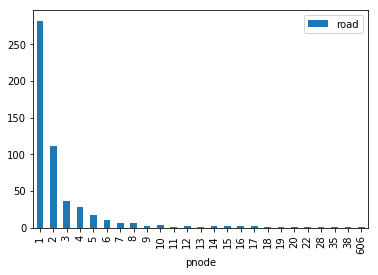

In [10]:
drop_off_group = colorful.groupby(by=["dnode"]).count().sort_values("road", ascending =False)

print("There are", len(drop_off_group.index.tolist()), "different drop off locations.")

nb_dropoffs_by_pnode = drop_off_group.drop(columns=["t",  "LengthRoad"])
#nb_dropoffs_by_pnode = nb_dropoffs_by_pnode.rename(index=str, columns={"pnode": "nb of x tuples dropoffs"})
   

nb_dropoffs_by_pnode.groupby("road").count()   
nb_dropoffs_by_pnode.groupby("pnode").count().plot.bar()

One data point contains 6 attributs: `plat`, `plng`, `dlat`, `t`  and `road`. 

In [11]:
colorful.describe()

,LengthRoad,pnode,dnode
count,2000.000000,2.000000e+03,2.000000e+03
mean,210.462500,2.089708e+09,1.792157e+09
std,105.143822,1.506250e+09,1.541335e+09
min,12.000000,5.040500e+05,2.806610e+05
25%,123.000000,5.630213e+08,5.615095e+08
50%,190.500000,2.223092e+09,6.224273e+08
75%,316.000000,2.223092e+09,3.357409e+09
max,651.000000,5.542663e+09,5.623968e+09


In [12]:
colorful["LengthRoad"].describe()

count    2000.000000
mean      210.462500
std       105.143822
min        12.000000
25%       123.000000
50%       190.500000
75%       316.000000
max       651.000000
Name: LengthRoad, dtype: float64

In [13]:
# Example of adding a second dictionary to our first one
dic = {}
dic[0] = 0.1, 0.2

# Save Dictionary
with open('testDictionary.json', 'w') as fp:
    json.dump(dic, fp)

dic = {}
dic[2] = 0.8, 0.2

with open('testDictionary.json', 'r') as fp:
    data = json.load(fp)
dic2 = {**dic, **data}

# Save Dictionary
with open('testDictionary.json', 'w') as fp:
    json.dump(dic2, fp)

In [14]:
# Building osm to lat and lng dictionary
# Max number of requests is around 100
chunk = allNodes[100:200]
d = buildOSMNodeToLatLngDictionary(chunk)

# Load Dictionary
with open('data/testDictionary.json', 'r') as fp:
    data = json.load(fp)

newDict = {**d, **data}
    
# Save Dictionary
with open('data/OSMToLatLngDictionary2.json', 'w') as fp:
    json.dump(newDict, fp)

HTTPError: HTTP Error 410: Gone